# Time series classification with sktime

The time series classification (TSC) task involves training a model from a collection
 of time series (real valued, ordered, data) in order to predict a target variable.
 For example, we might want to build a model that can predict whether a patient is
 sick based on the ECG reading, or predict whether a device will fail based on some
 sensor reading. This notebook gives a quick guide to get you started

## Data sets and problem types

The UCR/UEA [time series classification archive](https://timeseriesclassification.com/)
contains a large number of example TSC problems that have been used thousands of times
in the literature to assess TSC algorithms. These dataset have certain
characteristics, that influence what data structure we use to store them in memory.

Most datasets contain time series all of the same length. For example, the [arrow
head dataset](https://timeseriesclassification.com/description.php?Dataset=ArrowHead) consists of outlines of the images of arrow heads. The
classification of projectile points is an important topic in anthropology.
<img src="./img/arrow-heads.png" width="400" alt="arrow heads">

The shapes of the projectile points are converted into a sequence using the
angle-based method as described in this [blog post](https://izbicki.me/blog/converting-images-into-time-series-for-data-mining.html) about converting images into time series for data mining.

<img src="./img/from-shapes-to-time-series.png" width="400" alt="from shapes to time series">

Each instance consists of a single time series (i.e. the problem is univariate) of
equal length and a class label based on shape distinctions such as the presence and
location of a notch in the arrow. The data set consists of 21 instances, by
default split into 36 train and 175 test instances. We refer to the collection of
time series as $X$ and to the collection of class labels as $y$. This type of dataset
 is most naturally stored in a two dimensional numpy array for $X$ and one
 dimensional numpy array for $y$. for the single problem loader load arrow head, set 
 the return type to numpy2d or numpyflat to store $X$ in a 2D ndarray. 

(36, 251) (36,) (175, 251) (175,)


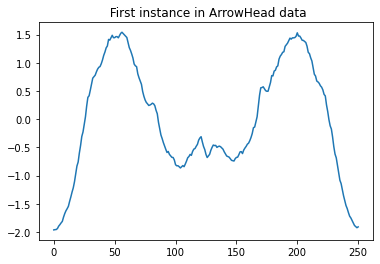

In [1]:
# Imports used in this notebook
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline

from sktime.classification.compose import ColumnEnsembleClassifier
from sktime.classification.dictionary_based import TemporalDictionaryEnsemble
from sktime.classification.hybrid import HIVECOTEV2
from sktime.classification.interval_based import DrCIF
from sktime.classification.kernel_based import RocketClassifier
from sktime.datasets import (
    load_arrow_head,
    load_basic_motions,
    load_japanese_vowels,
    load_plaid,
)
from sktime.transformations.panel.compose import ColumnConcatenator
from sktime.transformations.panel.tsfresh import TSFreshFeatureExtractor

In [ ]:
# Random train set for a two class problem with 10 instances of length 50
random_train_X = np.random.rand(10, 50)
random_train_y = np.random.randint(low=0, high=2, size=10)

# Load all arrow head
arrow_X, arrow_y = load_arrow_head(return_type="numpy2d")
# Load default train/test splits from sktime/datasets/data
arrow_train_X, arrow_train_y = load_arrow_head(split="train", return_type="numpy2d")
arrow_test_X, arrow_test_y = load_arrow_head(split="test", return_type="numpyflat")
print(arrow_train_X.shape, arrow_train_y.shape, arrow_test_X.shape, arrow_test_y.shape)
plt.title(" First instance in ArrowHead data")
plt.plot(arrow_train_X[0])

Some TSC datasets are multivariate, in that each instance has more than one
associated time series. For example, the problem [basic motions dataset](https://timeseriesclassification.com/description.php?Dataset=BasicMotions)
The data was generated as part of a student project where four students performed
four activities whilst wearing a smart watch. The watch collects 3D accelerometer and
 a 3D gyroscope. Each instance involved a subject performing one of four tasks (walking,
 resting, running and badminton) for ten seconds. The data has 6 dimensions. This 
 type of data is best stored as a three dimensional numpy array. To get a data 
 structure of this type from the single problem loader, use the return type argument 
 numpy3d as follows.

<class 'numpy.ndarray'>
(40, 6, 100) (40,) (40, 6, 100) (40,)


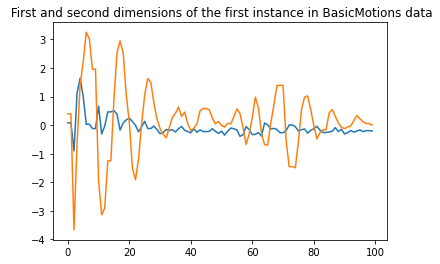

In [2]:
# Random train set for a multivariate two class problem with 10 instances of length 50
random_train_X = np.random.rand(10, 6, 50)
random_train_y = np.random.randint(low=0, high=2, size=10)

motions_X, motions_Y = load_basic_motions(return_type="numpy3d")
motions_train_X, motions_train_y = load_basic_motions(
    split="train", return_type="numpy3d"
)
motions_test_X, motions_test_y = load_basic_motions(split="test", return_type="numpy3d")
print(type(motions_train_X))
print(
    motions_train_X.shape,
    motions_train_y.shape,
    motions_test_X.shape,
    motions_test_y.shape,
)
plt.title(" First and second dimensions of the first instance in BasicMotions data")
plt.plot(motions_train_X[0][0])
plt.plot(motions_train_X[0][1])

Some data sets have unequal length series. Two data sets with this characteristic
are shipped with sktime: PLAID (univariate) and JapaneseVowels (multivariate). We
cannot store unequal length series in numpy arrays. Instead, we use nested pandas
data frames, where each cell is a pandas Series. This is the default return type for 
all single problem loaders.

<class 'pandas.core.frame.DataFrame'>


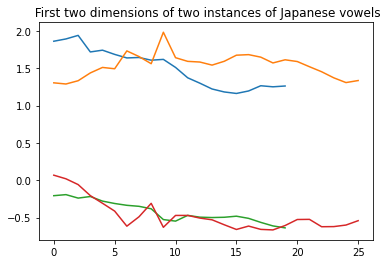

In [3]:
# loads both train and test together
vowel_X, vowel_y = load_japanese_vowels()
print(type(vowel_X))

plt.title(" First two dimensions of two instances of Japanese vowels")
plt.plot(vowel_X.iloc[0, 0])
plt.plot(vowel_X.iloc[1, 0])
plt.plot(vowel_X.iloc[0, 1])
plt.plot(vowel_X.iloc[1, 1])
plt.show()

<class 'pandas.core.frame.DataFrame'>


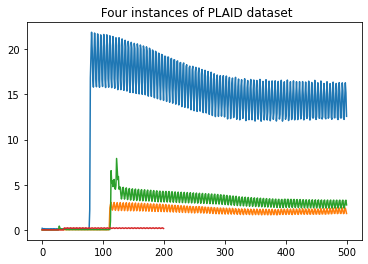

In [4]:
plaid_X, plaid_y = load_plaid()
print(type(plaid_X))

plt.title(" Four instances of PLAID dataset")
plt.plot(plaid_X.iloc[0, 0])
plt.plot(plaid_X.iloc[1, 0])
plt.plot(plaid_X.iloc[2, 0])
plt.plot(plaid_X.iloc[3, 0])
plt.show()

## Building Classifiers

We demonstrate the simplest use cases for classifiers and demonstrate how it is
possible to compose a bespoke pipeline classifier. You can use a standard sklearn
classifier for univariate, equal length classification problems but it is unlikely to
 perform as well as bespoke time series classifiers. You cannot use sklearn
 classifiers directly with multivariate or unequal length data
sets.

In [5]:
classifier = RandomForestClassifier(n_estimators=100)
classifier.fit(arrow_train_X, arrow_train_y)
y_pred = classifier.predict(arrow_test_X)
accuracy_score(arrow_test_y, y_pred)

0.7371428571428571

sktime contains the state of the art in time series classifiers in the package
classification. These are grouped based on their representation. An accurate and
relatively fast classifier is called [ROCKET](https://arxiv.org/abs/1910.13051)

In [6]:
rocket = RocketClassifier()
rocket.fit(arrow_train_X, arrow_train_y)
y_pred = rocket.predict(arrow_test_X)
accuracy_score(arrow_test_y, y_pred)

0.8057142857142857

The current state of the art for TSC is version 2 of the [HIVE-COTE algorithm](https://link.springer.com/article/10.1007/s10994-021-06057-9). HC2 is slow on small
problems like these examples. However, it can be configured with an approximate
maximum run time as follows.

In [7]:
hc2 = HIVECOTEV2(time_limit_in_minutes=1)
hc2.fit(arrow_train_X, arrow_train_y)
y_pred = hc2.predict(arrow_test_X)
accuracy_score(arrow_test_y, y_pred)

0.8742857142857143

Most classifiers in sktime involve some degree of transformation. The simplest form
is simply consisting of a pipeline of transformation followed by an sklearn
classifier. You can combine transformers and classifiers in a simple pipeline. for
example, you may want to use [tsfresh](https://tsfresh.readthedocs.io/en/latest/) to
extract features for a random forest classifier. This can be done with sktime
transformers as follows:

In [11]:
tsfresh = TSFreshFeatureExtractor(default_fc_parameters="minimal")
randf = RandomForestClassifier(n_estimators=100)
pipe = Pipeline(
    [
        ("transform", tsfresh),
        ("classifier", randf),
    ]
)
pipe.fit(arrow_train_X, arrow_train_y)
y_pred = pipe.predict(arrow_test_X)
accuracy_score(arrow_test_y, y_pred)

Feature Extraction: 100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


0.6171428571428571

## Multivariate classification
Many classifiers, including ROCKET and HC2, are configured to work with multivariate
input. For example

In [8]:
rocket.fit(motions_train_X, motions_train_y)
y_pred = rocket.predict(motions_test_X)
accuracy_score(motions_test_y, y_pred)
hc2.fit(motions_train_X, motions_train_y)
y_pred = hc2.predict(motions_test_X)
accuracy_score(motions_test_y, y_pred)

1.0

sktime offers two other ways of solving multivariate time series classification 
problems:

1. Concatenation of time series columns into a single long time series column via 
`ColumnConcatenator` and apply a classifier to the concatenated data,
2. Dimensiion ensembling via `ColumnEnsembleClassifier` in which one classifier is
 fitted for each time series column/dimension of the time series and their predictions 
 are combined through a voting scheme. 

We can concatenate multivariate time series/panel data into long univariate time 
series/panel using a tran and then apply a classifier to the univariate data.


In [2]:
steps = [
    ("concatenate", ColumnConcatenator()),
    ("classify", DrCIF(n_estimators=10)),
]
clf = Pipeline(steps)
clf.fit(motions_train_X, motions_train_y)
clf.score(motions_test_X, motions_test_y)

NameError: name 'motions_train_X' is not defined

We can also fit one classifier for each time series column and then aggregated their 
predictions. The interface is similar to the familiar `ColumnTransformer` from sklearn.

In [18]:
clf = ColumnEnsembleClassifier(
    estimators=[
        ("DrCIF0", DrCIF(n_estimators=10), [0]),
        ("TDE3", TemporalDictionaryEnsemble(max_ensemble_size=5), [3]),
    ]
)
clf.fit(motions_train_X, motions_train_y)
clf.score(motions_test_X, motions_test_y)

0.975

### Background info and references for classifiers used here

#### The RocketClassifier 
is based on a pipeline combination of the ROCKET transformation (transformations
.panel.rocket) and the sklearn RidgeClassifierCV classifier. The RocketClassifier is 
configurable to use variants minirocket and multirocket. ROCKET is based on 
generating random convolutions. A large number are generated then the classifier 
performs a feature selection.

[1] Dempster, Angus, François Petitjean, and Geoffrey I. Webb. "Rocket:
       exceptionally fast and accurate time series classification using random
       convolutional kernels." Data Mining and Knowledge Discovery 34.5 (2020)
[arXiv version](https://arxiv.org/abs/1910.13051)

#### DrCIF
The Diverse Representation Canonical Interval Forest Classifier (DrCIF) is an 
interval based classifier. The algorithm takes multiple randomised intervals from 
each series and extracts a range of features. These features are used to build a 
decision tree, which in turn are ensembled into a decision forest, in the style of a 
random forest. The original version 

[2] Matthew Middlehurst and James Large and Anthony Bagnall. "The Canonical
       Interval Forest (CIF) Classifier for Time Series Classification."
       IEEE International Conference on Big Data 2020
[arXiv version](https://arxiv.org/abs/2008.09172)

The DrCIF adjustment was proposed in [4]        
#### TDE
he Temporal Dictionary Ensemble is a dictionary based classifier. The basic premise 
is to extract discrete patterns using a windowing and to count their occurence. 
Classification is based on these frequency histograms. TDE includes bigram 
frequencies, spatial pyramids and a Gaussian process based parameter search. 

[3] Matthew Middlehurst, James Large, Gavin Cawley and Anthony Bagnall
        "The Temporal Dictionary Ensemble (TDE) Classifier for Time Series
        Classification", in proceedings of the European Conference on Machine Learning
        and Principles and Practice of Knowledge Discovery in Databases, 2020.
[arXiv version](https://arxiv.org/abs/2105.03841)

#### HiveCoteV2 (HC2)

The HIerarchical VotE Collective of Transformation-based Ensembles is a meta ensemble
 that combines classifiers built on different representations. Version 2 
 combines DrCIF, TDE, an ensemble of RocketClassifiers called the Arsenal and the 
 ShapeletTransformClassifier. It is currently the most accurate classifier on the UCR
  and UEA time series archives. 
   
[4] Middlehurst, Matthew, James Large, Michael Flynn, Jason Lines, Aaron Bostrom,
       and Anthony Bagnall. "HIVE-COTE 2.0: a new meta ensemble for time series
       classification." [Machine Learning (2021)](https://link.springer.com/article/10.1007/s10994-021-06057-9)